# Tutorial: Uninformed Search Algorithms

This tutorial shows how we can combine motion primitives of vehicles, i.e., short trajectory segments, with uninformed search algorithms to find feasible trajectories that connect the **initial state** and the **goal region** of a given planning problem.

## 0. Preparation
Before you proceed with this tutorial, make sure that

* you have gone through the tutorial for **CommonRoad Input-Output**.
* you have installed all necessary modules for **CommonRoad Search** according to the installation manual.

Let's start with importing relevant modules and classes for setting up the automaton and the CommonRoad (CR) scenario.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
path_notebook = os.getcwd()

# add the SMP folder to python path
sys.path.append(os.path.join(path_notebook, "../../"))

# add the 1_search_algorithms folder to python path
sys.path.append(os.path.join(path_notebook, "../"))

import matplotlib.pyplot as plt

from commonroad.common.file_reader import CommonRoadFileReader
from commonroad.visualization.draw_dispatch_cr import draw_object

from SMP.motion_planner.motion_planner import MotionPlanner
from SMP.maneuver_automaton.maneuver_automaton import ManeuverAutomaton
from SMP.motion_planner.utility import plot_primitives, display_steps

## 1. Loading CR Scenario and Planning Problem
In the next step, we load a CommonRoad scenario and its planning problem, which should be solved with the search algorithms. The meaning of the symbols in a scenario are explained as follows:
* **Dot**: initial state projected onto the position domain
* **Red rectangle**: static obstacle
* **Yellow rectangle**: goal region projected onto the position domain

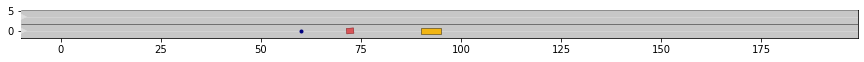

In [2]:
# load scenario
path_scenario = os.path.join(path_notebook, "../../scenarios/tutorial/")
id_scenario = 'ZAM_Tutorial_Urban-3_2'

# read in scenario and planning problem set
scenario, planning_problem_set = CommonRoadFileReader(path_scenario + id_scenario + '.xml').open()
# retrieve the first planning problem in the problem set
planning_problem = list(planning_problem_set.planning_problem_dict.values())[0]
    
# plot the scenario and the planning problem set
plt.figure(figsize=(15, 5))
draw_object(scenario)
draw_object(planning_problem_set)
plt.gca().set_aspect('equal')
plt.margins(0, 0)
plt.show()

## 2. Generating a Maneuver Automaton

In the following, we load the pre-generated motion primitives from an XML-File, and generate a **Maneuver Automaton** out of them.
The maneuver automaton used for this tutorial consists of 7 motion primitives; the connectivity within the motion primitives are also computed and stored. Some additional explanations on the motion primitives:
* The motion primitives are generated for the *Kinematic Single Track Model* (see [Vehicle Model Documentation](https://gitlab.lrz.de/tum-cps/commonroad-vehicle-models/-/blob/master/vehicleModels_commonRoad.pdf)) with parameters taken from vehicle model *BMW320i* (id_type_vehicle=2). 
* The motion primitives have a constant driving velocity of 9 m/s, varying steering angles with constant steering angle velocity, and a duration of 0.5 seconds. We assume constant input during this period.
* The motion primitives are generated for all combinations of the steering angles of values 0 rad and 0.2 rad at the initial state and the final state, thereby producing 2 (initial states) x 2 (final states) = 4 primitives. Except for the primive moving straight (with 0 rad steering angle at the initial and the final states), the remaining 3 left-turning primitives are mirrored with regard to the x-axis, resulting in a total number of 7 motion primitives.
* Two motion primitives are considered connectable if the velocity and the steering angle of the final state of the preceding primitive are equal to those of the initial state of the following primitive.

In [ ]:
# load the xml with stores the motion primitives
name_file_motion_primitives = 'V_9.0_9.0_Vstep_0_SA_-0.2_0.2_SAstep_0.2_T_0.5_Model_BMW_320i.xml'

# generate automaton
automaton = ManeuverAutomaton.generate_automaton(name_file_motion_primitives)

# plot motion primitives
plot_primitives(automaton.list_primitives)

## 3. Search algorithms
Next, we demonstrate the search results for the following algorithms:
1. Breadth-First Search (BFS)
2. Depth-First Search (DFS)
3. Depth-Limited Search (DLS)
4. Uniform-Cost Search (UCS)

For each of the algorithms, we create a corresponding motion planner implemented in the **MotionPlanner** class, with the scenario, the planning problem, and the generated automaton as the input. The source codes are located at **SMP/motion_planner/search_algorithms/**

After executing the code block for every algorithm, you will see a **"visualize"** button directly beneath the **"iteration"** slider. Click the **"visualize"** button and let the search algorithm run through; once it's completed, you can use the slider to examine all intermediate search steps. Meaning of colors and lines are explained as follows:
* **Yellow solid:** frontier 
* **Yellow dashed:** collision
* **Red solid:** currently exploring
* **Gray solid:** explored
* **Green solid:** final solution

### 3.1 Breadth-First Search (BFS)
The BFS algorithm uses a FIFO (First-In First-Out) queue for pushing the nodes.

In [ ]:
# construct motion planner
planner_BFS = MotionPlanner.BreadthFirstSearch(scenario=scenario, 
                                               planning_problem=planning_problem,
                                               automaton=automaton)
# prepare input for visualization
scenario_data = (scenario, planner_BFS.state_initial, planner_BFS.shape_ego, planning_problem)

# display search steps
display_steps(scenario_data=scenario_data, algorithm=planner_BFS.execute_search, 
              config=planner_BFS.config_plot)

### 3.2 Depth-First Search (DFS)
The DFS algorithm uses a LIFO (Last-In First-Out) queue for pushing the nodes.

In [ ]:
# construct motion planner
planner_DFS = MotionPlanner.DepthFirstSearch(scenario=scenario, 
                                             planning_problem=planning_problem,
                                             automaton=automaton)
# prepare input for visualization
scenario_data = (scenario, planner_DFS.state_initial, planner_DFS.shape_ego, planning_problem)

# display search steps
display_steps(scenario_data=scenario_data, algorithm=planner_DFS.execute_search, 
              config=planner_DFS.config_plot)

In this scenario, we were lucky enough to find a solution using DFS. However, the DFS is not complete, i.e., DFS is not guaranteed to find a solution if one exist. To justify our claim, we slightly manipulate the scenario, such that the goal region is shifted for 4 m in the y-axis, and re-run the search.

In [ ]:
import numpy as np

# read in scenario and planning problem set
scenario, planning_problem_set = CommonRoadFileReader(path_scenario + id_scenario + '.xml').open()
# retrieve the first planning problem in the problem set
planning_problem = list(planning_problem_set.planning_problem_dict.values())[0]

for state in planning_problem.goal.state_list:
    state.position = state.position.translate_rotate(np.array([0, 4]), 0)
    
# Plot the scenario and the planning problem set
plt.figure(figsize=(15, 5))
draw_object(scenario)
draw_object(planning_problem_set)
plt.gca().set_aspect('equal')
plt.margins(0, 0)
plt.show()

In [ ]:
# construct motion planner
planner_DFS = MotionPlanner.DepthFirstSearch(scenario=scenario, 
                                             planning_problem=planning_problem,
                                             automaton=automaton)
# prepare input for visualization
scenario_data = (scenario, planner_DFS.state_initial, planner_DFS.shape_ego, planning_problem)

# display search steps
display_steps(scenario_data=scenario_data, algorithm=planner_DFS.execute_search, 
              config=planner_DFS.config_plot)

As you can see, in this case DFS was not able to find a solution, since DFS would go infinitely deep when appending motion primitives (leading to infinite state space). **Question**: is this also the case with BFS? You can test it out.

To overcome this problem, we introduce a depth limit, resulting in Depth-Limited Search (DLS).

### 3.3 Depth-Limited Search (DLS)

Now let's run the algorithm and see what changes with the introduced depth limit. Here we set the limit to 7, as we know from the result of BFS that there exists a solution consisting of 7 motion primtives.

In [ ]:
limit_depth = 7

# construct motion planner
planner_DLS = MotionPlanner.DepthLimitedSearch(scenario=scenario, 
                                               planning_problem=planning_problem,
                                               automaton=automaton)
# prepare input for visualization
scenario_data = (scenario, planner_DLS.state_initial, planner_DLS.shape_ego, planning_problem)

# display search steps
display_steps(scenario_data=scenario_data, algorithm=planner_DLS.execute_search, 
              config=planner_DLS.config_plot, limit_depth=limit_depth)

As you can see, DLS now finds a solution. **Question**: what happends if you have a lower or higher depth limit? Try it out.

### 3.4 Uniform-Cost Search (UCS)

The algorithms we have considered so far do not consider any cost during the search process. In the following, we look at the Uniform-Cost Search. UCS is optimal for any step costs, as it expands the node with the lowest path cost g(n). In this example, the cost is set to the time to reach the goal. Thus, our cost g(n) is the time it took to reach our current final state. 

UCS is based on the Best-First Search algorithm, which we will also use for Greedy-Best-First Search and A\* Search in the next tutorial. These algorithms only differ in their evaluation function: in UCS, the evaluation function is f(n) = g(n).

In [ ]:
# read in scenario and planning problem set
scenario, planning_problem_set = CommonRoadFileReader(path_scenario + id_scenario + '.xml').open()
# retrieve the first planning problem in the problem set
planning_problem = list(planning_problem_set.planning_problem_dict.values())[0]

# construct motion planner
planner_UCS = MotionPlanner.UniformCostSearch(scenario=scenario, 
                                              planning_problem=planning_problem,
                                              automaton=automaton)
# prepare input for visualization
scenario_data = (scenario, planner_UCS.state_initial, planner_UCS.shape_ego, planning_problem)

# display search steps
display_steps(scenario_data=scenario_data, algorithm=planner_UCS.execute_search, 
              config=planner_UCS.config_plot)

## Congratulations!

You have finished the tutorial on uninformed search algorithms! Next, you can proceed with the tutorial on informed search algorithms.